# Power Dependant Spin Initialization Measurements

In [57]:
from qutip import *

import numpy as np
from numpy import pi as pi
from numpy import exp as exp
from numpy import sqrt as sqrt

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['font.size'] = 12
from scipy.optimize import curve_fit as cf

In [75]:
c0 = 299792458

def boltzmann(gs, T):
    return np.exp(-6.26e-34*gs*1e9/(1.38e-23*T))

def sigmoid(t, risetime, t0):
    a = risetime/(2*4.4)
    return 1/(np.exp(-(t-t0)/a)+1)

def pulse_sig(t, t0, width, risetime=1):
    return np.where(t<width/2+t0, sigmoid(t,risetime,t0),1-sigmoid(t,risetime,t0+width)).astype(float)

def pulse_rect(t, t0, width):
    return np.where( (t0<t) & (t<(width+t0)), 1.0, 0.0).astype(float)

def bin_data(xs, ys, res):
    xs_binned = np.zeros(int(xs.size//res))
    ys_binned = np.zeros_like(xs_binned)
    
    for i in range(int(xs.size//res)-1):
        xs_binned[i] = np.mean(xs[res*i:res*i+1])
        ys_binned[i] = np.mean(ys[res*i:res*i+1])
    
    xs_binned[-1] = np.mean(xs[-int(xs.size%res):-1])
    ys_binned[-1] = np.mean(ys[-int(xs.size%res):-1])
    
    return xs_binned, ys_binned

def aom_setpoint(setpoint):
    a, m, b, c = -1.31870938e-04,  9.82828974e-01,  9.48657630e-05, -8.76167714e-05
    return a*setpoint**m + b*exp(setpoint) + c

Power dependant spin initialization measurements by pumping spin-cycling transitions and measuring the pump duration. <br>
Here, power is actually the setpoint of the AOM which controls the total power. As a reference, for the following AOM setpoints the total optical power has been measured:
- 0.38 : 34(nW),
- 0.39 : 52(nW),
- 0.4 : 78(nW)


In [50]:
power_dep_files = {
    '030.csv':0.3,
    '033.csv':0.33,
    '034.csv':0.34,
    '035.csv':0.35,
    '036.csv':0.36,
    '037.csv':0.37,
    '038.csv':0.38,
    '039.csv':0.39
#     '040.csv':0.4
}

cmap = mpl.cm.get_cmap("viridis", len(power_dep_files))
kwargs_data = {
    'ls':'', 
    'marker':'o', 
    'markerfacecolor':'#fff',
    'markersize':5
#     'alpha':.5
}
kwargs_fit = {
    'linestyle':'-', 
    'linewidth':2,
    'alpha':.5
}
kwargs_fills = {
    'linestyle': '--',
    'linewidth': 2,
    'edgecolor': '#666',
    'alpha':.3
}

C:\Users\Marco\AppData\Local\Temp\ipykernel_4372\404071915.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ts, cts = ts[mask], cts[mask]
C:\Users\Marco\AppData\Local\Temp\ipykernel_4372\404071915.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([round(xtick*1e6) for xtick in axs[0].get_xticks()])
C:\Users\Marco\AppData\Local\Temp\ipykernel_4372\404071915.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels([round(ytick*1e-6) for ytick in axs[1].get_yticks()])


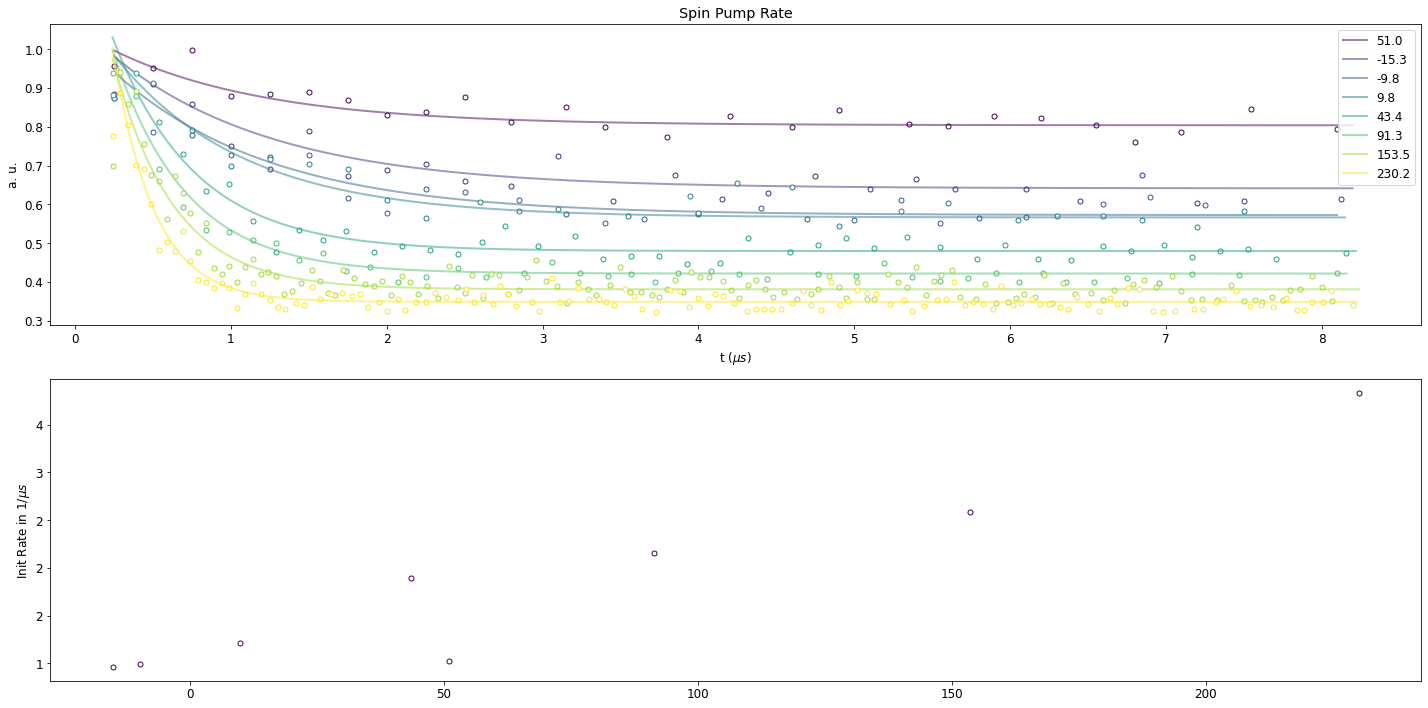

In [80]:
fig, axs = plt.subplots(2)

init_rates = np.zeros(len(power_dep_files))
powers = np.zeros_like(init_rates)
for i, (file, setpoint) in enumerate(power_dep_files.items()):
    ts = []
    cts = []
    power = round(aom_setpoint(setpoint)*1e9, 1)
    with open(file) as f:
        lines = f.readlines()
        
        for line in lines[1:]:      
            t, ct = (line.split(",")[:-1])
            ts.append(t)
            cts.append(ct)
    
    ts = np.array(ts, dtype=float)
    cts = np.array(cts, dtype=float)
    cts /= np.amax(cts)
    mask = [np.argwhere(cts > np.median(cts)).flatten()]
    ts, cts = ts[mask], cts[mask]
    
    axs[0].plot(*bin_data(ts, cts, 5), color=cmap(i), **kwargs_data)        
    x_fit, y_fit = ts, cts
    exp_dec = lambda t, T, A, c: A*exp(-t/T) + c
    p0 = 100e-9, np.amax(y_fit)-np.amin(y_fit), np.amin(y_fit)
    popt, pcov = cf(exp_dec, x_fit, y_fit, p0=p0)
    axs[0].plot(x_fit, exp_dec(x_fit, *popt), color=cmap(i), **kwargs_fit, label=str(power))
    
    powers[i] = power
    init_rates[i] = 1/popt[0]
    
axs[0].legend(title='')
axs[0].set_xlabel("t $(\mu s)$")
axs[0].set_ylabel("a. u.")
axs[0].set_title("Spin Pump Rate")
axs[0].set_xticklabels([round(xtick*1e6) for xtick in axs[0].get_xticks()])

axs[1].plot(powers, init_rates, color=cmap(0), **kwargs_data)
axs[1].set_yticklabels([round(ytick*1e-6) for ytick in axs[1].get_yticks()])
axs[1].set_ylabel("Init Rate in $1/\mu s$")
# axs[1].plot(powers, init_rates, color=cmap(0), **kwargs_fit)
plt.tight_layout()
plt.show()        

In [3]:
g1 = basis(6,0)
g2 = basis(6,1)
m1 = basis(6,2)
m2 = basis(6,3)
e1 = basis(6,4)
e2 = basis(6,5)

def initialize_collapses(gs, T, eta_spin, eta_opt, T1_opt, T1_spin):
    # 40ns is measured @5K and 46GHz ground-state splitting
    T1_orb = (46/gs)**3*40
    
    Gamma1_opt = 1/(2*pi*T1_opt)
    Gamma1_spin = 1/(2*pi*T1_spin)
    Gamma1_orb = 1/(1+boltzmann(gs,T))*1/(2*pi*T1_orb)
    
    Gamma1_orb_em = Gamma1_orb
    Gamma1_orb_abs = boltzmann(gs, T) * Gamma1_orb_em
    c_ops = [
    sqrt(Gamma1_opt)*(g1 + 1/eta_spin*g2 + 1/eta_opt*(1/eta_spin*m1 + m2))*e2.dag(),
    sqrt(Gamma1_opt)*(g1 + 1/eta_spin*g2 + 1/eta_opt*(m1 + 1/eta_spin*m2))*e1.dag(),
    (sqrt(Gamma1_orb_em) * g1 + sqrt(Gamma1_spin)*m2)*m1.dag(),
    (sqrt(Gamma1_orb_em) * g2 + sqrt(Gamma1_spin)*m1)*m2.dag(),
    (sqrt(Gamma1_orb_abs) * m1 + sqrt(Gamma1_spin)*g2)*g1.dag(),
    (sqrt(Gamma1_orb_abs) * m2 + sqrt(Gamma1_spin)*g1)*g2.dag()
    ]
    return c_ops

In [71]:
ts = np.arange(0, 300, 1)
Omegas = np.arange(0.1, 5, 0.3) * 1/(2*pi*1.7)
etas_spin = np.arange(1, 5, 1)

init_pop = np.zeros((len(Omegas), len(ts)))
Gammas_init = np.zeros((len(Omegas), len(etas_spin)))

for i, Omega in enumerate(Omegas):
    for j, eta_spin in enumerate(etas_spin):

        Hinit = Omega/2 * (g2*e2.dag() + e2*g2.dag())
        c_ops = initialize_collapses(gs=600, 
                                     T=5, 
                                     eta_spin=eta_spin, 
                                     eta_opt=2, 
                                     T1_opt=1.7, 
                                     T1_spin=400)
        e_ops = [e1*e1.dag(), e2*e2.dag()]
        rho0 = steadystate(Qobj(np.zeros((6,6))), c_ops)
        
        exps = mesolve(Hinit, rho0, ts, e_ops=e_ops, c_ops=c_ops).expect
        pop = exps[0] + exps[1]        
        init_pop[i]  = pop
        
        exp_decay = lambda x, A, Gamma, c: A*np.exp(-Gamma*x) + c            
        x, y = ts[np.argmax(pop):]-ts[np.argmax(pop)], init_pop[i][np.argmax(pop):]
        popt, pcov = cf(exp_decay, 
                        x, y, 
                        p0=(np.amax(y), 1/100, np.amin(y)))
        Gammas_init[i, j] = popt[1]

    #     plt.plot(ts[np.argmax(pop):]-ts[np.argmax(pop)], init_pop[i][np.argmax(pop):])
    #     plt.plot(x, exp_decay(x, *popt))
    #     plt.show()

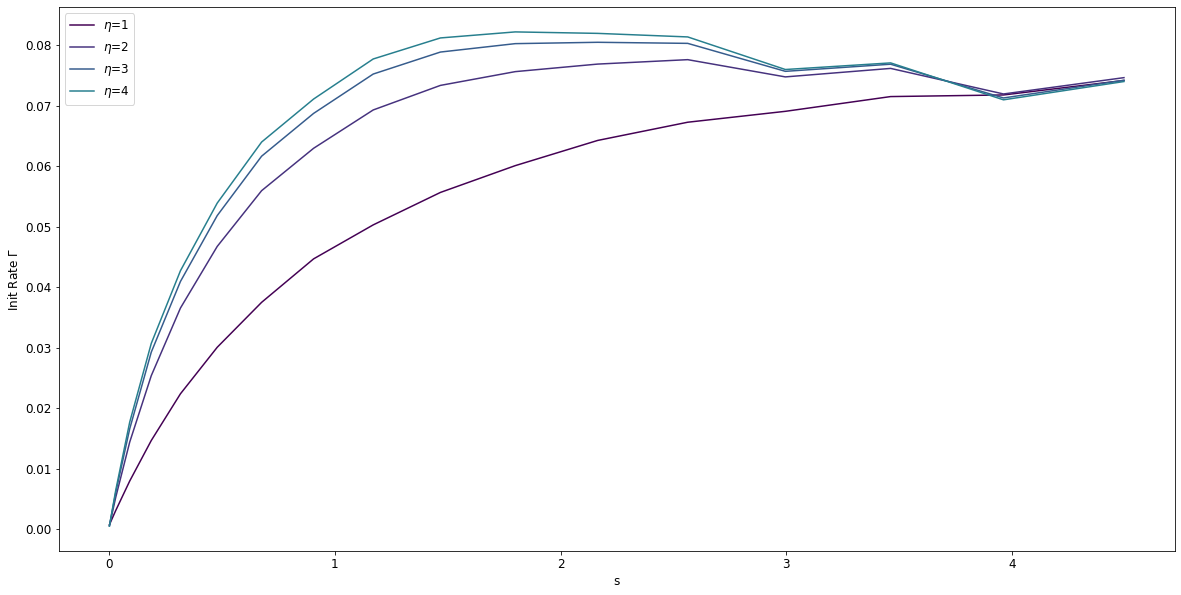

In [72]:
for j, eta_spin in enumerate(etas_spin):
    Gamma1_opt = 1/(2*pi*1.7)
    s = 2*Omegas**2/Gamma1_opt
    plt.plot(s, Gammas_init[:, j], label='$\eta$=' + str(eta_spin), color=cmap(j))
plt.legend()
plt.xlabel("s")
plt.ylabel("Init Rate $\Gamma$")
plt.show()